<a href="https://colab.research.google.com/github/mgnarag/machine-learning/blob/main/model_64_portion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!ls drive/My\ Drive
file_path = "/content/drive/My Drive/CS284/Project/"

In [3]:

import time
import pandas as pd


import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


from PIL import Image, ImageOps
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

import cv2

epoch = 100
model_number = 64
size = 64


# Generate augmented images with specific rotations
zoom_factor = [x/5 for x in range(6, 16)]


def zoom_and_resize(img, zoom_factor):
    height, width = img.shape[:2]

    # Calculate the region to crop around the center
    crop_top = int((height - height / zoom_factor) / 2)
    crop_bottom = int(height - crop_top)
    crop_left = int((width - width / zoom_factor) / 2)
    crop_right = int(width - crop_left)
    # Crop the image
    cropped_image = img[crop_top:crop_bottom, crop_left:crop_right]
    # Resize the zoomed image back to the original dimensions
    resized_image = cv2.resize(cropped_image, (width, height))

    return resized_image

def crop(im):
    width, height = im.size
    data = []

    for j in np.arange(0,int(height/size)+1,0.8):
        for i in np.arange(0,int(width/size)+1,0.8):
            im1 = im.crop((0 + (size*i), 0 + (size*j), size + (size*i), size + (size*j)))
            im1 = np.array(im1)
            im1 = im1.astype(np.float32)
            #im1 = im1/255
            data.append(im1/255)
            flip_im1 = np.fliplr(im1)

            rotated_90 = np.rot90(im1)
            data.append(rotated_90/255)
            rotated_90 = np.rot90(rotated_90) #180
            data.append(rotated_90/255)
            rotated_90 = np.rot90(rotated_90) #270
            data.append(rotated_90/255)
            #flip
            rotated_90 = np.rot90(flip_im1)
            data.append(rotated_90/255)
            rotated_90 = np.rot90(rotated_90) #180
            data.append(rotated_90/255)
            rotated_90 = np.rot90(rotated_90) #270
            data.append(rotated_90/255)


            # Define the zoom factor (e.g., 1.2 for 20% zoom in)
            for z in zoom_factor:
                zoomed_img = zoom_and_resize(im1, z)
                data.append(zoomed_img/255)



    return data

data = []

input = np.array(crop(Image.open(file_path + "CROP_WB_ViganII_NAP.png").convert('RGB')))
print("Done reading the input of size = ", input.shape)

output = np.array(crop(Image.open(file_path + "CROP_CLEAN_ViganII_NAP.png").convert('RGB')))
print("Done reading the output of size = ", input.shape)

train_input = []
test_input = []
for i in range(0,len(input)):
    if i % 4 == 0:
        test_input.append(input[i])
    else:
        train_input.append(input[i])

train_input = np.array(train_input)
test_input = np.array(test_input)

print("Done reading the train input of size = ", train_input.shape)
print("Done reading the test input of size = ", test_input.shape)
input = []

train_output = []
test_output = []
for i in range(0,len(output)):
    if i % 4 == 0:
        test_output.append(output[i])
    else:
        train_output.append(output[i])

train_output = np.array(train_output)
test_output = np.array(test_output)

print("Done reading the train output of size = ", train_input.shape)
print("Done reading the test output of size = ", test_input.shape)

output = []


Done reading the input of size =  (20808, 64, 64, 3)
Done reading the output of size =  (20808, 64, 64, 3)
Done reading the train input of size =  (15606, 64, 64, 3)
Done reading the test input of size =  (5202, 64, 64, 3)
Done reading the train output of size =  (15606, 64, 64, 3)
Done reading the test output of size =  (5202, 64, 64, 3)


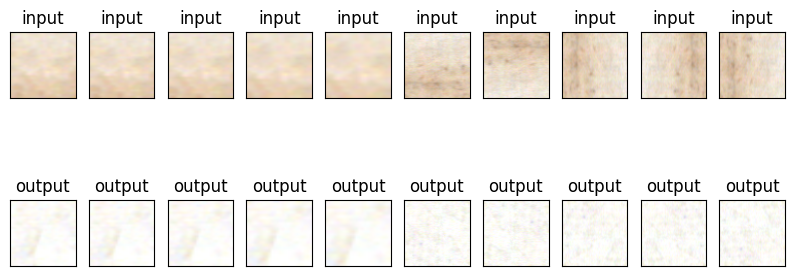

In [4]:

n = 10
plt.figure(figsize=(10, 4))
for i in range(0,10):

    ax = plt.subplot(2, n, i + 1)
    plt.title("input")
    plt.imshow((train_input[i+6000]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    bx = plt.subplot(2, n, i + n + 1)
    plt.title("output")
    plt.imshow((train_output[i+6000]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()



In [5]:

import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model


class autoenc(Model):
  def __init__(self):
    super(autoenc, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(size, size, 3)),
      layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=1),
      #layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=1),
      layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2),
      #layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=1),
      layers.Conv2D(256, (3, 3), activation='relu', padding='same', strides=2)])
      #layers.Conv2D(256, (3, 3), activation='relu', padding='same', strides=1)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(128, kernel_size=3, strides=2, activation='relu', padding='same'),
      #layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=1),
      layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
      #layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=1),
      layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = autoenc()




In [6]:
from keras.optimizers import Adam
opt = Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=opt, loss=losses.MeanSquaredError())


start = time.time()
model = autoencoder.fit(train_input, train_output,
                epochs=epoch,
                shuffle=True,
                validation_data=(test_input, test_output),batch_size=16)

autoencoder.encoder.summary()


autoencoder.save(file_path + 'autoencoder_' + str(model_number)+'_portion')

loss = model.history['loss']
loss = pd.DataFrame(loss)
loss.to_csv(file_path + 'loss_autoencoder_'+ str(model_number) + '_portion.csv')
val_loss = model.history['val_loss']
val_loss = pd.DataFrame(val_loss)
val_loss.to_csv(file_path  +'val_loss_autoencoder_'+ str(model_number) + '_portion.csv')

# record end time
end = time.time()

print("The time of execution of above program is :",
      (end-start), "seconds")

Epoch 1/100
976/976 [==============================] - 27s 21ms/step - loss: 0.0176 - val_loss: 0.0013
Epoch 2/100
976/976 [==============================] - 19s 20ms/step - loss: 0.0011 - val_loss: 8.6045e-04
Epoch 3/100
976/976 [==============================] - 19s 20ms/step - loss: 8.7443e-04 - val_loss: 7.7648e-04
Epoch 4/100
976/976 [==============================] - 20s 20ms/step - loss: 7.9497e-04 - val_loss: 7.3488e-04
Epoch 5/100
976/976 [==============================] - 20s 20ms/step - loss: 7.3567e-04 - val_loss: 6.8931e-04
Epoch 6/100
976/976 [==============================] - 19s 20ms/step - loss: 7.1457e-04 - val_loss: 6.8518e-04
Epoch 7/100
976/976 [==============================] - 19s 19ms/step - loss: 6.7828e-04 - val_loss: 6.1901e-04
Epoch 8/100
976/976 [==============================] - 19s 20ms/step - loss: 6.6081e-04 - val_loss: 6.5144e-04
Epoch 9/100
976/976 [==============================] - 19s 20ms/step - loss: 6.4785e-04 - val_loss: 6.0491e-04
Epoch 10/100


In [ ]:

from tensorflow import keras
from PIL import Image, ImageOps
import numpy as np

n_size = 64
def crop_(im):
    width, height = im.size
    data = []
    for j in range(0,int(height/n_size)):
        for i in range(0,int(width/n_size)):
            im1 = im.crop((0 + (n_size*i), 0 + (n_size*j), n_size + (n_size*i), n_size + (n_size*j)))
            im1 = np.array(im1)
            im1 = im1.astype(np.float32)
            im1 = im1/255
            data.append(im1)
    return data


#filename = str('[WB] 1885_Mactan_NAP_FelixPelayo.png')
#filename = str("1885_Mactan_NAP_FelixPelayo.tiff")
filename = str("[WB] 1872_Mindanao_NAP_D.FedericoCaballero.tif")
#filename = str("[WB] XXXX_Cagayan y Ilocos_online.png")
test = Image.open(file_path+ "Testing nbs/" + filename)
test = test.convert('RGB')
w_dirty, h_dirty = test.size


autoencoder = keras.models.load_model(file_path + 'unet_64')


xx = int(w_dirty/n_size)
final=[]

for portion in range(0,xx):
    im1 = test.crop((n_size*portion, 0, (n_size*portion) + n_size, h_dirty))
    w1, h1 = im1.size
    w = int(w1/n_size)
    h = int(h1/n_size)

    neverbeforeseen = np.array(crop_(im1))
    #encoded_imgs = autoencoder.encoder(neverbeforeseen).numpy()
    decoded_imgs = autoencoder.predict(neverbeforeseen)

    col = np.vstack((decoded_imgs[0],decoded_imgs[1]))
    for i in range(2,h):
        col = np.vstack((col,decoded_imgs[i]))

    #y = np.where(col > 0.5,1,0) #round the values
    y= col
    y = (y * 255).astype('uint8')
    if portion == 0:
        final = y
    if portion > 0:
        final = np.hstack((final,y))

final = np.squeeze(final)
reconstructed = Image.fromarray(final)
reconstructed.save(file_path + "Testing nbs/"+"CLEAN_Unet64"+filename)